# Predict Delivery Duration for DoorDash

## Problem Statement
Getting the expected delivery right is very important for DoorDash as it has big impact on customer experience. There are two things worth to be noted:
1. Order lateness / underprediction of delivery time is of particular concern as past experiments suggest that underestimating delivery time is roughly twice as costly as overestimating it
2. Orders that are very early / late are also much worse than those that are only slightly early / late.

## Data
historical_data.csv

## Metrics
### 1. Mean Squared Errors (MSE)

MSE is the most commonly used performance metric for regression models on continuous numeric dependent variable. It is also the main part of the Loss function, aside from the regularization term if any. I choose to use MSE in this case because it works well in the 2nd situation mentioned in the Problem Statement about the very early/late orders. Since the errors are squared, it penalizes larger deviation much more than the smaller deviation.

### 2. R-squared

R-squared score is called the Coefficient of Determination, calculated by 1 - (residual sum of squares / total sum of squares). Because we will use the same testing dataset to cross validate different models, the "total sum of squares" stays the same. While "residual sum of squares" is just MSE times Degree of Freedom so they both represent the same thing, meaning that the R-squared score should agree with the MSE metric for the same model. R-squared is just more intuitive because it has 1 as the benchmark of "perfect prediction" and 0 as no difference than just taking the mean.


### 3. Shapley Value

Shapley Value is a concept in Coalitional Game Theory, and is also often used in the Machine Learning territory to interprete the contribution of a feature value to the difference between the actual prediction and the mean prediction. Such interpretation is easy to be made for certain models such as Linear Regression or Logistic Regression (just look at the coefficients) as they are straight forward, but not so much for the "Black Box-ish" Machine Learning models like ensemble models. This is where the Shapley Value comes into play to help with model interpretation. For more details check out these materials: https://christophm.github.io/interpretable-ml-book/shapley.html

### 4. Customized Metrics

The Item 1 in the Problem Statement above describes a situation that, from the business's perspective, the cost of positive errors and negative errors are not equal. Because "underestimating delivery time is roughly twice as costly as overestimating it", the evaluation metric should put more weight on positive errors (Y_i > Y-hat_i); similarly, this should be incorporated into the Loss function to penalize positive errors harder than negative errors, then we may arrive at different predictions than using MSE in the Loss function. 

Therefore, in addition to the prediction which ought to have least errors, I'll also talk about the customized metric and a new prediction which may bring in some bias and have larger overall error but should work in a better way for the business.

## Final Predictions

I provided 2 columns of predictions: 

1. The one "prediction_with_MSE" is the prediction given directly by the model using MSE as its Loss function; 

2. The other one "prediction_with_new_metric" is a refined prediction on the basis of "prediction_with_MSE" tuned via using the customized metric. I believe the 2nd one will play good to the business.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
#from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score
import shap
from pickle import dump, load


%matplotlib inline

In [2]:
# Read data
df = pd.read_csv(
    'historical_data.csv', 
    header=0
)

df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


## Data Exploration, Visualization and Pre-processing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
market_id                                       196441 non-null float64
created_at                                      197428 non-null object
actual_delivery_time                            197421 non-null object
store_id                                        197428 non-null int64
store_primary_category                          192668 non-null object
order_protocol                                  196433 non-null float64
total_items                                     197428 non-null int64
subtotal                                        197428 non-null int64
num_distinct_items                              197428 non-null int64
min_item_price                                  197428 non-null int64
max_item_price                                  197428 non-null int64
total_onshift_dashers                           181166 non-null float64
total_busy_dashers                      

### Note: 

The dataset has 197428 rows, and from the info we can see certain columns have missing values issue. This needs to be dealt with later on.

In [4]:
# The response variable is not directly provided in the dataset and needs to be calculated from other features
# From df.info() we can see there are a few rows where the actual delivery time is null. These rows need to be removed
# from modeling because they cannot derive the response variable.

df.dropna(subset=['actual_delivery_time','created_at'], inplace=True)

df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['created_at'] = pd.to_datetime(df['created_at'])

df['total_delivery_duration_seconds'] = df[['actual_delivery_time', 'created_at']].apply(
    lambda x: pd.Timedelta(x[0] - x[1]).total_seconds(), 
    axis=1
)

In [5]:
# Descriptive Stats on the response variable
df['total_delivery_duration_seconds'].describe()

count    1.974210e+05
mean     2.908257e+03
std      1.922961e+04
min      1.010000e+02
25%      2.104000e+03
50%      2.660000e+03
75%      3.381000e+03
max      8.516859e+06
Name: total_delivery_duration_seconds, dtype: float64

### Note:

We can clearly see there are some outliers with delivery duration that makes no sense, for example the shortest delivery time can be less than 2 mins and the longest is 2300+ hours. I believe one potential reason for the multi-hour-long delivery orders is that these are the orders with pre-scheduled delivery time as opposed to the common ASAP orders. It's possible some people like to pre-order their dinner many hours ahead. But still, there can be errors such as the dasher forgot to click the delivery button after finishing the delivery, leading to the long delivery duration records. I decided to consider any order with delivery duration under 5 mins or above 12 hours as outliers and eliminate them from modeling.

In addition, I think the dataset is better to provide other features like "order_type", which contains information about whether the order is pre-scheduled or ASAP order; and another feature like "order_sent_dt" which records the timestamp when DoorDash really sent the order to the restaurant for those pre-scheduled orders (I assume such orders are not sent immediately but accordingly based on the prescheduled delivery time by the customer). Without such information, the model will not perform very well because the ASAP orders and scheduled orders are mixed together, and there a big chunk of time should NOT be counted for the scheduled orders as delivery duration.

In [6]:
# Remove outlier orders with delivery duration less than 5 mins or more than 12 hours
df.drop(
    df[(df['total_delivery_duration_seconds'] < (5*60)) | (df['total_delivery_duration_seconds'] > (12*60*60))].index,
    inplace=True
)

In [7]:
df['total_delivery_duration_seconds'].describe()

count    197411.000000
mean       2860.640471
std        1143.242253
min         321.000000
25%        2104.000000
50%        2660.000000
75%        3381.000000
max       39352.000000
Name: total_delivery_duration_seconds, dtype: float64

### Note:

Now we have a workable response variable (y). We can move on to data cleansing/preprocessing and feature engineering on the predictive variables (Vector X).

In [8]:
# Remove highly irrelevant features such as the IDs
# market_id, store_id and order_protocol were found for this dataset
print(df['market_id'].value_counts())
print(df['store_id'].value_counts())
print(df['order_protocol'].value_counts())

2.0    55050
4.0    47596
1.0    38034
3.0    23295
5.0    17999
6.0    14450
Name: market_id, dtype: int64
6865    936
1311    863
314     814
1686    765
3937    721
       ... 
5637      1
5676      1
505       1
5509      1
4398      1
Name: store_id, Length: 6743, dtype: int64
1.0    54722
3.0    53195
5.0    44287
2.0    24048
4.0    19352
6.0      793
7.0       19
Name: order_protocol, dtype: int64


In [9]:
df.groupby('market_id').describe()['total_delivery_duration_seconds']

,count,mean,std,min,25%,50%,75%,max
market_id,,,,,,,,
1.0,38034.0,3078.548404,1320.217541,406.0,2178.00,2814.0,3695.0,38143.0
2.0,55050.0,2762.793588,1036.020792,321.0,2080.25,2601.0,3245.0,39352.0
3.0,23295.0,2859.765787,1158.520481,470.0,2104.00,2646.0,3372.0,36196.0
4.0,47596.0,2834.192180,1090.086485,386.0,2105.00,2664.5,3362.0,32159.0
5.0,17999.0,2789.726096,1072.538925,619.0,2070.00,2605.0,3285.5,22912.0
6.0,14450.0,2835.517578,1188.020803,557.0,2069.00,2615.5,3343.0,38457.0


In [10]:
df.groupby('order_protocol').describe()['total_delivery_duration_seconds']

,count,mean,std,min,25%,50%,75%,max
order_protocol,,,,,,,,
1.0,54722.0,2995.632488,1179.101812,386.0,2207.0,2790.0,3553.0,38457.0
2.0,24048.0,2840.210537,1124.607574,321.0,2101.0,2647.0,3346.0,22512.0
3.0,53195.0,2810.564094,1074.422824,325.0,2100.0,2626.0,3303.0,36196.0
4.0,19352.0,2903.062681,1279.259007,516.0,2046.0,2658.5,3439.0,22912.0
5.0,44287.0,2734.373044,1098.151896,386.0,2014.0,2546.0,3236.0,39352.0
6.0,793.0,3612.254729,1385.846131,1099.0,2640.0,3404.0,4325.0,13036.0
7.0,19.0,2482.210526,827.828859,1083.0,2006.0,2170.0,2830.0,4445.0


### Note:

store_id: Even though denoted by numbers, this feature is not meant to be ordinal so it is taken as categorical. It has too many categories which is not feasible for modeling. Although this feature may contain certain information since each restaurant has its baseline speed making food, such information can also be somehow inferred and picked up by the model via other features like store_primary_category. So it's decided to remove this feature from further analysis.

market_id and order_protocol: These two features do not contain too many categories so it's feasible to do one-hot encoding for them. In addition, we can see the mean and median(50%) varies to a certain level across different groups for these 2 features, meaning they have some useful information in them. So it's decided to keep them.

In [11]:
df.drop(['store_id'],axis=1, inplace=True)

In [12]:
# Now deal with missing values
df.isnull().mean()

market_id                                       0.005000
created_at                                      0.000000
actual_delivery_time                            0.000000
store_primary_category                          0.024112
order_protocol                                  0.005040
total_items                                     0.000000
subtotal                                        0.000000
num_distinct_items                              0.000000
min_item_price                                  0.000000
max_item_price                                  0.000000
total_onshift_dashers                           0.082371
total_busy_dashers                              0.082371
total_outstanding_orders                        0.082371
estimated_order_place_duration                  0.000000
estimated_store_to_consumer_driving_duration    0.002664
total_delivery_duration_seconds                 0.000000
dtype: float64

### Note:

We can see the "store_primary_category" has about 2.4% missing values, we can assign it to UNKNOWN category. And we can do the same to "market_id" and "order_protocol" with 0 to denote UNKNOWN.

"estimated_store_to_consumer_driving_duration" has very tiny percent of missing values (under 0.5%) and it's hard to think of any good imputation for it, so it's OK to just drop these NA rows.

"total_onshift_dashers", "total_busy_dashers" and "total_outstanding_orders" have about 8% missing values and it is some information loss if just delete the rows. The dasher data is highly dymanic and varies much with time and location. I think of one way of imputation is to take the mean # of dashers from the rows where order creation timestamp is filtered by within (-5min, +5min) of this order, and account for this restaurant itself and all nearby restaurants. However, this dataset doesn't give restaurants' geo location so impossible to find the rows for its nearby restaurants, and each restaurant alone cannot guarantee to have sufficient amount of orders(rows) within every 10 mins window. Therefore, I have to give up this idea.

It will be very helpful if the dataset can include geo information of each restaurant so we can do missing value imputation of the dynamic # of dasher features. 

In [13]:
df['store_primary_category'].fillna(value='UNKNOWN', inplace=True)
df['market_id'].fillna(value=0.0, inplace=True)
df['order_protocol'].fillna(value=0.0, inplace=True)

df.dropna(subset=['estimated_store_to_consumer_driving_duration'],inplace=True)
df.dropna(subset=['total_onshift_dashers','total_busy_dashers','total_outstanding_orders'],inplace=True)

In [14]:
df.isnull().mean()

market_id                                       0.0
created_at                                      0.0
actual_delivery_time                            0.0
store_primary_category                          0.0
order_protocol                                  0.0
total_items                                     0.0
subtotal                                        0.0
num_distinct_items                              0.0
min_item_price                                  0.0
max_item_price                                  0.0
total_onshift_dashers                           0.0
total_busy_dashers                              0.0
total_outstanding_orders                        0.0
estimated_order_place_duration                  0.0
estimated_store_to_consumer_driving_duration    0.0
total_delivery_duration_seconds                 0.0
dtype: float64

### Note:

Done with missing values. Looks good.

In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
market_id,180668.0,2.734734,1.342679,0.0,2.0,2.0,4.00,6.0
order_protocol,180668.0,2.881252,1.525277,0.0,1.0,3.0,4.00,7.0
total_items,180668.0,3.208903,2.673301,1.0,2.0,3.0,4.00,411.0
subtotal,180668.0,2699.147768,1828.966843,0.0,1418.0,2225.0,3414.25,26800.0
num_distinct_items,180668.0,2.678150,1.627432,1.0,2.0,2.0,3.00,20.0
min_item_price,180668.0,684.874488,521.275743,-86.0,299.0,595.0,942.00,14700.0
max_item_price,180668.0,1161.030537,561.897782,0.0,799.0,1095.0,1395.00,14700.0
total_onshift_dashers,180668.0,44.819979,34.540684,-4.0,17.0,37.0,65.00,171.0
total_busy_dashers,180668.0,41.754345,32.158275,-5.0,15.0,34.0,62.00,154.0
total_outstanding_orders,180668.0,58.071042,52.681714,-6.0,17.0,41.0,85.00,285.0


### Note:

From the descriptive stats above we can see there are some data points with bad data entry, because it doesn't make sense for any item being negative price, or negative number of dashers or orders. We need to take a closer look at these entries and determine what to do with them. 

In [16]:
df[(df['min_item_price']<0) | (df['total_onshift_dashers']<0) | (df['total_busy_dashers']<0) | (df['total_outstanding_orders']<0)]

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds
790,1.0,2015-01-29 02:59:28,2015-01-29 03:44:09,fast,4.0,3,1003,3,-86,1066,24.0,29.0,38.0,251,721.0,2681.0
1351,2.0,2015-02-06 05:26:55,2015-02-06 06:15:41,fast,4.0,35,1786,4,-1,488,33.0,36.0,52.0,251,587.0,2926.0
4989,1.0,2015-02-18 00:36:21,2015-02-18 01:12:28,smoothie,2.0,2,1940,1,840,856,11.0,14.0,-2.0,251,460.0,2167.0
6034,3.0,2015-02-14 01:48:58,2015-02-14 03:00:13,american,1.0,2,3538,2,1238,1606,-2.0,2.0,10.0,446,266.0,4275.0
7997,1.0,2015-02-08 15:41:45,2015-02-08 16:35:01,sandwich,3.0,1,1514,1,1116,1063,1.0,-1.0,3.0,251,650.0,3196.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188786,3.0,2015-02-11 14:41:00,2015-02-11 15:37:46,american,1.0,1,1345,1,957,1113,2.0,-2.0,23.0,446,609.0,3406.0
190628,3.0,2015-02-05 20:16:54,2015-02-05 21:10:23,seafood,4.0,3,2238,3,740,768,-1.0,5.0,10.0,251,738.0,3209.0
191717,3.0,2015-02-05 16:41:17,2015-02-05 17:30:26,cafe,1.0,5,2338,4,266,942,8.0,-2.0,8.0,446,213.0,2949.0
192887,1.0,2015-02-01 04:54:41,2015-02-01 05:37:57,italian,3.0,2,5240,2,2516,2644,-2.0,5.0,6.0,251,172.0,2596.0


### Note:

We have 92 rows with this issue, that's about 0.05% of the total rows. Now we may choose to delete these rows and we lose 0.05% of total information, which is not a big deal; or we can choose to substitute these negative values with 0 and keep these rows since many other columns still have useful information for these rows. 

It is up to the Data Scientist's judgement call. Here I prefer to keep them now. One can always come back to revisit another option, after an optimal model has been selected, to see if taking another option will change the model's coefficients/parameters by much.

In [17]:
# Substitute these negative values with 0
col_list = ['min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']

for col in col_list:
    df[col] = df[col].apply(lambda x: x if x>=0 else 0.0)

In [18]:
# Check it again
df[(df['min_item_price']<0) | (df['total_onshift_dashers']<0) | (df['total_busy_dashers']<0) | (df['total_outstanding_orders']<0)]

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds


### Note:

It shows we have fixed the issue on these 92 rows. We can move on.

In [19]:
# Check features with high correlation
df.corr(method='pearson')

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds
market_id,1.000000,-0.005405,0.001833,-0.002022,0.013016,-0.008949,-0.005111,0.068678,0.059531,0.062586,-0.047626,0.016754,-0.054039
order_protocol,-0.005405,1.000000,0.005607,-0.052198,-0.026316,-0.041127,-0.088046,0.143142,0.147703,0.133146,-0.676454,-0.009656,-0.070353
total_items,0.001833,0.005607,1.000000,0.557361,0.759736,-0.389305,-0.053903,0.031649,0.028552,0.034295,-0.023955,0.007289,0.113651
subtotal,-0.002022,-0.052198,0.557361,1.000000,0.681384,0.038867,0.508580,0.130868,0.125619,0.130094,0.034645,0.038137,0.208151
num_distinct_items,0.013016,-0.026316,0.759736,0.681384,1.000000,-0.445845,0.046612,0.065873,0.060583,0.067746,0.003102,0.024958,0.152813
min_item_price,-0.008949,-0.041127,-0.389305,0.038867,-0.445845,1.000000,0.542613,0.042315,0.043832,0.040933,0.052102,0.004400,0.013298
max_item_price,-0.005111,-0.088046,-0.053903,0.508580,0.046612,0.542613,1.000000,0.133008,0.130921,0.130561,0.084509,0.028486,0.128347
total_onshift_dashers,0.068678,0.143142,0.031649,0.130868,0.065873,0.042315,0.133008,1.000000,0.943731,0.936155,-0.185618,0.045897,0.068032
total_busy_dashers,0.059531,0.147703,0.028552,0.125619,0.060583,0.043832,0.130921,0.943731,1.000000,0.932907,-0.191783,0.044487,0.087598
total_outstanding_orders,0.062586,0.133146,0.034295,0.130094,0.067746,0.040933,0.130561,0.936155,0.932907,1.000000,-0.172463,0.039756,0.176102


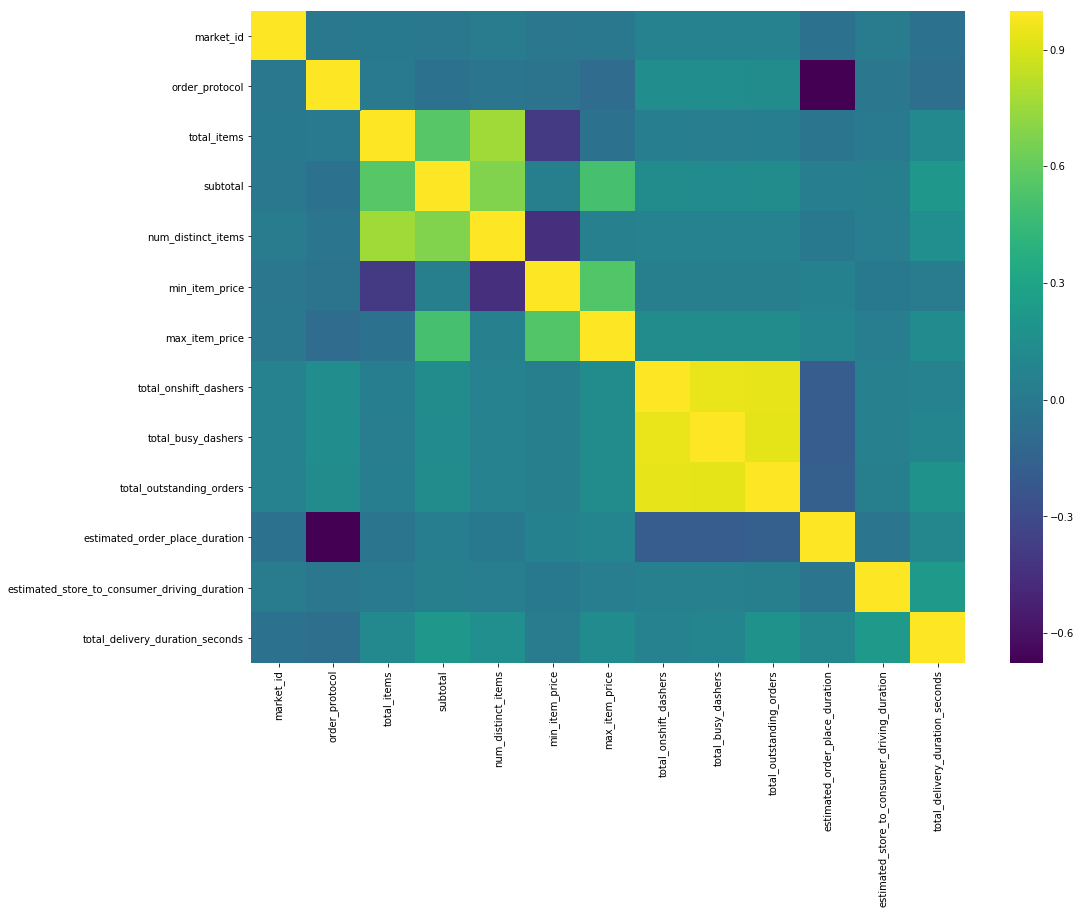

In [20]:
# Visualize the correlation
plt.figure(
        figsize=[16,12]
)

sns.heatmap(
        data=df.corr(), 
        cmap='viridis', 
        annot=False, 
        fmt='.2g'
)

### Note:

With this heatmap, it easy to spot high correlation which is an early sign of multicollinearity among the features of (total_items, subtotal, num_distinct_items) and (total_onshift_dashers, total_busy_dashers, total_outstanding_orders).

The very high negative correlation between "estimated_order_place_duration" and "order_protocol" can be ignored for now because "order_protocol" is not meant to be ordinal and we will do one-hot encoding of it.

Considering the common rule-of-thumb of 0.7 as being high correlation, I decide to remove the features of "num_distinct_items", "total_busy_dashers" and "total_outstanding_orders".

In [21]:
df.drop(['num_distinct_items','total_busy_dashers','total_outstanding_orders'],axis=1, inplace=True)

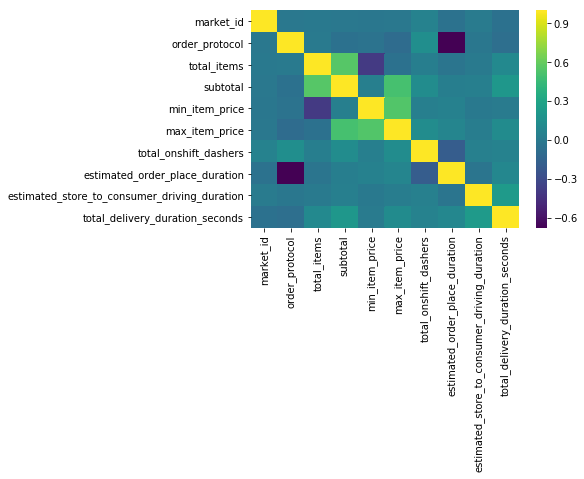

In [22]:
sns.heatmap(
        data=df.corr(), 
        cmap='viridis', 
        annot=False, 
        fmt='.2g'
)

### Note:

After the response variable being created, the two timestamps "created_at" and "actual_delivery_time" can be dropped. But before doing it, I'm going to use "created_at" do create another binary feature "rush_hour" as an indication whether the dasher possibly will be driving in heavy traffic or not. In fact, "actual_delivery_time" is the better one to use to estimate this feature because of the "ASAP vs pre-scheduled" order type issue; but it won't be feasible for prediction because we do not have "actual_delivery_time" in the data to predict. Therefore, we will use "created_at".

To utilize the new feature "rush_hour", we need to know the timezone each "market_id"(city) is in. In the Data Description it says "in case you need it, the actual timezone of the region was US/Pacific" so for now we just consider all markets in this dataset are in PST. We only do one transformation on the timestamp from UTC to PST. However, in the future it's better to add a new feature to show the timezone of each market, in case it's been expending to across different timezones. It will help us to derive more accurate "rush_hour" indicator. Or, it's even better to just provide the "rush_hour" information directly in the dataset for better modeling.

In [23]:
# According to general information, we will define rush hour as 6:00–10:00 and 15:00–19:00.
df['rush_hour'] = df['created_at'].apply(lambda x: 1 if (x - pd.Timedelta(8, unit='h')).hour in [6,7,8,9,15,16,17,18] else 0)

In [24]:
df.drop(['created_at','actual_delivery_time'],axis=1, inplace=True)

In [25]:
# Categorical Variables and Dummy Variables
df['store_primary_category'].nunique()

74

### Note:

"store_primary_category" has 74 categories and not quite feasible to do one-hot encoding. We will first use visualization to spot if it is helpful in predicting delivery duration then decide what to do with it.

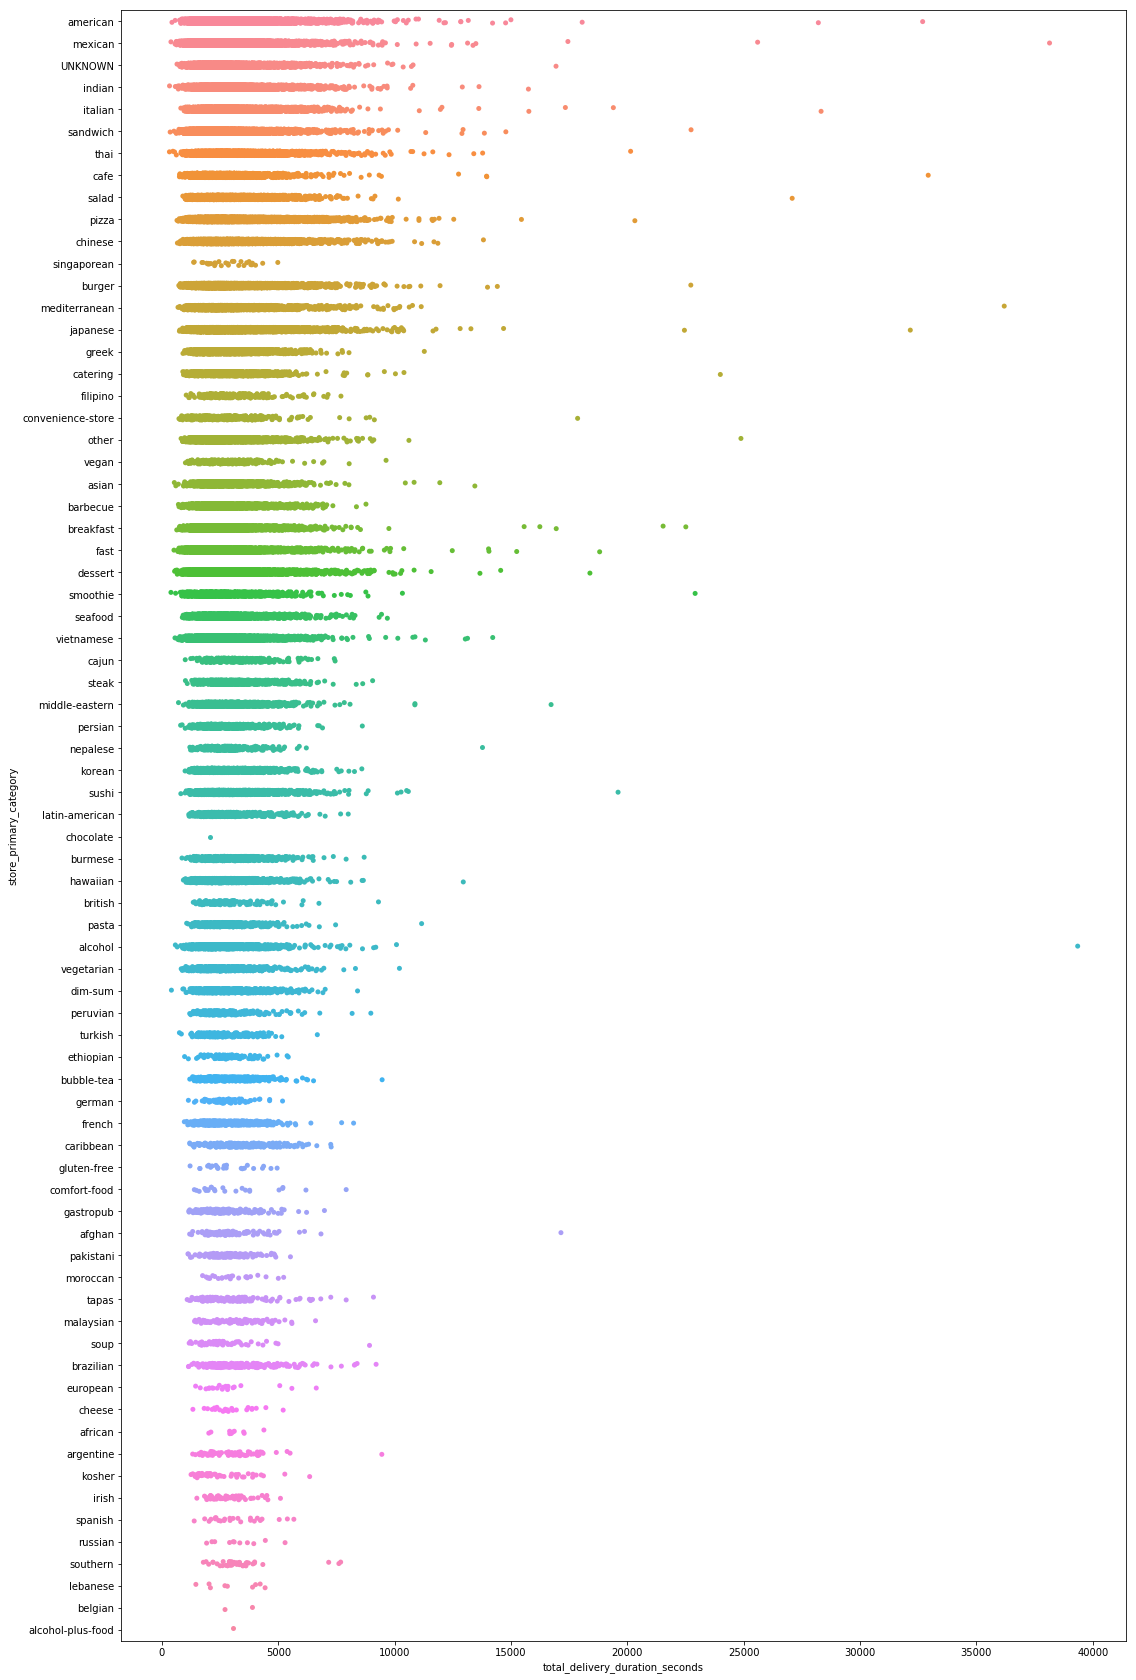

In [26]:
plt.figure(
        figsize=[18,30]
)
sns.stripplot(x="total_delivery_duration_seconds", y="store_primary_category", data=df,jitter=True)

### Note:

Hmmm...hard to conclude it. From the graph above we can clearly see the store category can make a difference on the response, that's for sure; but the difference is not that obvious enough to distinguish every category. Anyway I decide to keep this feature even though it will generate 70+ dummy variables. Ensemble models may be able to pick up the pattern in it. I'll just leave the hard work to them!

In [27]:
# Now, for all the categorical features, create dummy variables
cate_list = ['market_id','store_primary_category','order_protocol']

df = pd.get_dummies(
        df, 
        columns=cate_list, 
        drop_first=True
)

In [28]:
# Seperate the predictive features (X) and the response (y)

X = df.drop('total_delivery_duration_seconds', axis=1)
y = df['total_delivery_duration_seconds']

Xfeature_list = X.columns.tolist()

## Note:

So far we are pretty much done with the data preparation steps and shall begin modeling. But before we jump into that, here are some questions regarding how we are going to do modeling that we need to think through.

### 1. Given the size of the dataset you have, do you want to do K-fold cross validation?

For sure we need to do cross validation, but I'm not planning to manually do K-fold. K-fold is meant for the situation that the dataset is relatively small. Since we got about 180k observations which is quite sufficient, I'm just going to do regular train-test split cross validation. In addition, when I use GridSearchCV to train ML models, the algorithm is using 5-fold cross validation by default. So I do not need to do it manually on the training sample.

### 2. Hey, you got over 90 features in your X matrix, do you want to do dimension reduction to bring it down?

Indeed we can use Principle Component Analysis to bring down the # of features from 90+ to about only 2,3 or 4 components, and it only leaves out much noise/non-important information, with the major information still kept in the low-rank approximation of the original matrix X. But, it is working at the cost of losing the intuitive interpretability. Because each component is a mixture of all the features with different proportions, so it's hard to explain to people which original features are the important ones and how much are they contributing to the final predictions. Especially I still want to use Shapley Value to interpret the contribution of each feature to the ML model so I cannot aggregate them into components. I'll do modeling with the original features.

### 3. Are you going to normalize your data? If yes, with what method?

Yes I'll normalize the data because we have some quite large values in certain features compared to other features, and I want the model to assume equal importance of all features at the begining so I need to do normalization. In addition, since I'll try some Gradient Descent algorithm, such algorithm is more likely to fail when X is larger (learning rate is fixed) because the algorithm makes giant leaps toward the very close target W while baby steps are needed. This overshooting will make the loss oscillate or explode. This is the 2nd reason why I need to normalize it.

I'll choose Min-Max scaler because it's common and won't mess with the dummy variables.


### 4. What models are you planning to build?

I'll start from Linear Regression, then go to SVM, Random Forest(Bagging), and then Boosting(Adaboost and Gradient Boost). I'm not going to use XGBoost because it's designed for very large and complex data, and won't show much merit over regular Gradient Boost if not tried on Big Data. Lastly I'll build a deep neural network to see how it goes. I'll use the metrics mentioned in the top of this notebook to evaluate and pick the final model.


## Modeling

In [29]:
# Train Test Split
# Using random_state=101 to make the result replicable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [30]:
# Normalizing the Data with MinMaxScaler
# Fit and transform the train data; but only transform the test data without fit to prevent data leakage

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Linear Regression

We will mostly use the sklearn to do Linear Regression. However, Linear Regression is based on the assumption of the normality of residuals and we need to have that test passed to have a valid regression. The statsmodels library can do the regression as well as provide multiple test results together in a report, which is very convenient so we will start from there. Once the normality is tested and good, we will switch to sklearn to train the model and do prediction.

In [31]:
# Fit the regression and get the report
sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     total_delivery_duration_seconds   R-squared:                       0.140
Model:                                         OLS   Adj. R-squared:                  0.139
Method:                              Least Squares   F-statistic:                     218.6
Date:                             Sat, 14 Nov 2020   Prob (F-statistic):               0.00
Time:                                     03:34:23   Log-Likelihood:            -1.0601e+06
No. Observations:                           126467   AIC:                         2.120e+06
Df Residuals:                               126372   BIC:                         2.121e+06
Df Model:                                       94                                         
Covariance Type:                         nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1183.1284     55.875     21.175      0.000    1073.615    1292.641
x1           460.0568    114.793      4.008      0.000     235.065     685.049
x2          2496.4071     77.550     32.191      0.000    2344.410    2648.404
x3          -274.1769    113.777     -2.410      0.016    -497.178     -51.176
x4           821.0820    123.526      6.647      0.000     578.973    1063.190
x5           637.5068     18.559     34.351      0.000     601.132     673.881
x6          4047.8617    217.530     18.608      0.000    3621.506    4474.217
x7          2475.4950     28.672     86.338      0.000    2419.298    2531.692
x8           148.0353      6.113     24.218      0.000     136.054     160.016
x9           253.1658     48.369      5.234      0.000     158.364     347.968
x10         -189.8013     48.158     -3.941      0.000    -284.190     -95.413
x11           34.0772     48.712      0.700      0.484     -61.398     129.552
x12         -130.1769     48.208     -2.700      0.007    -224.664     -35.689
x13          -67.1802     48.830     -1.376      0.169    -162.886      28.526
x14          -11.0643     68.837     -0.161      0.872    -145.984     123.855
x15          352.6246    122.358      2.882      0.004     112.805     592.444
x16         -247.3363    374.547     -0.660      0.509    -981.443     486.770
x17         -135.3974     36.807     -3.679      0.000    -207.538     -63.257
x18         -175.7750   1057.790     -0.166      0.868   -2249.025    1897.475
x19          -16.6299     22.601     -0.736      0.462     -60.927      27.667
x20          -43.7049    162.765     -0.269      0.788    -362.721     275.311
x21          -80.9032     33.721     -2.399      0.016    -146.996     -14.811
x22         -149.2584     31.988     -4.666      0.000    -211.955     -86.562
x23          799.9963   1057.763      0.756      0.449   -1273.201    2873.193
x24          467.1371     77.959      5.992      0.000     314.339     619.935
x25         -115.1360     27.502     -4.186      0.000    -169.039     -61.233
x26          125.1444    112.884      1.109      0.268     -96.107     346.395
x27          221.7819     63.358      3.500      0.000      97.602     345.961
x28          -18.1032     24.403     -0.742      0.458     -65.932      29.726
x29          133.8584     54.831      2.441      0.015      26.391     241.326
x30          -83.4243     35.762     -2.333      0.020    -153.517     -13.332
x31           94.9142     74.780      1.269      0.204     -51.653     241.481
x32          143.0866     80.368      1.780      0.075     -14.433     300.606
x33            8.2578     38.139      0.217      0.829     -66.494      83.010
x34         -580.

### Note:

In the bottom of the report, both Omnibus and Jarque-Bera tests are rejecting the normality of residuals with p-value close to 0; in addition, the poor R-squared(0.14) is also suggesting this is a terrible fit. So Linear Regression is not fitting into this situation and we can forget about it.

## Support Vector Machine

The general idea of SVM is to start with data in a relatively low dimension and project them into a higher dimension for calculation; but it is not actually doing the transformation into higher dimension, instead it uses Kernel functions as proxy so it reduces the amount of computation and even make the calculations in infinite dimensions possible (Radial Basis Function). In our situation, our data is already high dimensional with relatively large sample size so it makes me a little worried about the time and resources it takes to train an SVM model. Let's see.

I'll be using SVM regressor. Since SVM has many hyperparameters that work together to affect the model's performance, I'm going to use GridSearchCV to let sklearn do the heavy work and find me the best hyperparameters.

### Note(after the 1st trial of SVM):

The training process is really slow so I have to reduce the sample size. I'll only take the first 12k rows (about 10%) of the training set. Since it was already random splited so the first 12k is equavalent to random 12k. While I reduce the sample size, I'll not do dimension reduction because SVM algorithm is meant to work well with high dimensional data and this should not be the main factor making it slow.

In [49]:
# Pick hyperparameter candidates

param_grid = {
    'C': [0.1,1, 10, 100, 1000], 
    'gamma': [1,0.1,0.01,0.001],
    'epsilon': [0.1, 0.5, 1],
    'kernel': ['rbf','poly']
}

# ATTENTION!! This training step takes long time! It was like 3 hours for me.
grid_SVM = GridSearchCV(
    SVR(),
    param_grid=param_grid,
    verbose=3
)

grid_SVM.fit(X_train[:12000], y_train[:12000])

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] C=0.1, epsilon=0.1, gamma=1, kernel=rbf .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, epsilon=0.1, gamma=1, kernel=rbf, score=-0.032, total=  17.3s
[CV] C=0.1, epsilon=0.1, gamma=1, kernel=rbf .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s remaining:    0.0s


[CV]  C=0.1, epsilon=0.1, gamma=1, kernel=rbf, score=-0.036, total=  17.0s
[CV] C=0.1, epsilon=0.1, gamma=1, kernel=rbf .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.3s remaining:    0.0s


[CV]  C=0.1, epsilon=0.1, gamma=1, kernel=rbf, score=-0.044, total=  17.1s
[CV] C=0.1, epsilon=0.1, gamma=1, kernel=rbf .........................
[CV]  C=0.1, epsilon=0.1, gamma=1, kernel=rbf, score=-0.021, total=  17.1s
[CV] C=0.1, epsilon=0.1, gamma=1, kernel=rbf .........................
[CV]  C=0.1, epsilon=0.1, gamma=1, kernel=rbf, score=-0.025, total=  17.0s
[CV] C=0.1, epsilon=0.1, gamma=1, kernel=poly ........................
[CV]  C=0.1, epsilon=0.1, gamma=1, kernel=poly, score=0.011, total=  14.2s
[CV] C=0.1, epsilon=0.1, gamma=1, kernel=poly ........................
[CV]  C=0.1, epsilon=0.1, gamma=1, kernel=poly, score=0.010, total=  14.2s
[CV] C=0.1, epsilon=0.1, gamma=1, kernel=poly ........................
[CV]  C=0.1, epsilon=0.1, gamma=1, kernel=poly, score=-0.007, total=  14.8s
[CV] C=0.1, epsilon=0.1, gamma=1, kernel=poly ........................
[CV]  C=0.1, epsilon=0.1, gamma=1, kernel=poly, score=0.021, total=  14.3s
[CV] C=0.1, epsilon=0.1, gamma=1, kernel=poly ..

[CV]  C=0.1, epsilon=0.5, gamma=0.1, kernel=poly, score=-0.021, total=  14.5s
[CV] C=0.1, epsilon=0.5, gamma=0.1, kernel=poly ......................
[CV]  C=0.1, epsilon=0.5, gamma=0.1, kernel=poly, score=-0.025, total=  14.4s
[CV] C=0.1, epsilon=0.5, gamma=0.01, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.5, gamma=0.01, kernel=rbf, score=-0.033, total=  17.5s
[CV] C=0.1, epsilon=0.5, gamma=0.01, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.5, gamma=0.01, kernel=rbf, score=-0.036, total=  17.7s
[CV] C=0.1, epsilon=0.5, gamma=0.01, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.5, gamma=0.01, kernel=rbf, score=-0.044, total=  18.6s
[CV] C=0.1, epsilon=0.5, gamma=0.01, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.5, gamma=0.01, kernel=rbf, score=-0.021, total=  19.9s
[CV] C=0.1, epsilon=0.5, gamma=0.01, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.5, gamma=0.01, kernel=rbf, score=-0.025, total=  17.9s
[CV] C=0.1, epsilon=0.5, gam

[CV]  C=0.1, epsilon=1, gamma=0.001, kernel=rbf, score=-0.025, total=  17.4s
[CV] C=0.1, epsilon=1, gamma=0.001, kernel=poly ......................
[CV]  C=0.1, epsilon=1, gamma=0.001, kernel=poly, score=-0.033, total=  14.6s
[CV] C=0.1, epsilon=1, gamma=0.001, kernel=poly ......................
[CV]  C=0.1, epsilon=1, gamma=0.001, kernel=poly, score=-0.037, total=  14.6s
[CV] C=0.1, epsilon=1, gamma=0.001, kernel=poly ......................
[CV]  C=0.1, epsilon=1, gamma=0.001, kernel=poly, score=-0.045, total=  14.9s
[CV] C=0.1, epsilon=1, gamma=0.001, kernel=poly ......................
[CV]  C=0.1, epsilon=1, gamma=0.001, kernel=poly, score=-0.021, total=  15.3s
[CV] C=0.1, epsilon=1, gamma=0.001, kernel=poly ......................
[CV]  C=0.1, epsilon=1, gamma=0.001, kernel=poly, score=-0.026, total=  15.1s
[CV] C=1, epsilon=0.1, gamma=1, kernel=rbf ...........................
[CV]  C=1, epsilon=0.1, gamma=1, kernel=rbf, score=-0.027, total=  17.4s
[CV] C=1, epsilon=0.1, gamma=1, ke

[CV]  C=1, epsilon=0.5, gamma=0.1, kernel=rbf, score=-0.020, total=  17.1s
[CV] C=1, epsilon=0.5, gamma=0.1, kernel=rbf .........................
[CV]  C=1, epsilon=0.5, gamma=0.1, kernel=rbf, score=-0.022, total=  16.9s
[CV] C=1, epsilon=0.5, gamma=0.1, kernel=rbf .........................
[CV]  C=1, epsilon=0.5, gamma=0.1, kernel=rbf, score=-0.031, total=  16.8s
[CV] C=1, epsilon=0.5, gamma=0.1, kernel=rbf .........................
[CV]  C=1, epsilon=0.5, gamma=0.1, kernel=rbf, score=-0.007, total=  17.1s
[CV] C=1, epsilon=0.5, gamma=0.1, kernel=rbf .........................
[CV]  C=1, epsilon=0.5, gamma=0.1, kernel=rbf, score=-0.011, total=  16.7s
[CV] C=1, epsilon=0.5, gamma=0.1, kernel=poly ........................
[CV]  C=1, epsilon=0.5, gamma=0.1, kernel=poly, score=-0.032, total=  14.7s
[CV] C=1, epsilon=0.5, gamma=0.1, kernel=poly ........................
[CV]  C=1, epsilon=0.5, gamma=0.1, kernel=poly, score=-0.035, total=  14.8s
[CV] C=1, epsilon=0.5, gamma=0.1, kernel=poly .

[CV]  C=1, epsilon=1, gamma=0.01, kernel=poly, score=-0.045, total=  15.8s
[CV] C=1, epsilon=1, gamma=0.01, kernel=poly .........................
[CV]  C=1, epsilon=1, gamma=0.01, kernel=poly, score=-0.021, total=  14.9s
[CV] C=1, epsilon=1, gamma=0.01, kernel=poly .........................
[CV]  C=1, epsilon=1, gamma=0.01, kernel=poly, score=-0.026, total=  16.2s
[CV] C=1, epsilon=1, gamma=0.001, kernel=rbf .........................
[CV]  C=1, epsilon=1, gamma=0.001, kernel=rbf, score=-0.033, total=  17.0s
[CV] C=1, epsilon=1, gamma=0.001, kernel=rbf .........................
[CV]  C=1, epsilon=1, gamma=0.001, kernel=rbf, score=-0.036, total=  17.1s
[CV] C=1, epsilon=1, gamma=0.001, kernel=rbf .........................
[CV]  C=1, epsilon=1, gamma=0.001, kernel=rbf, score=-0.044, total=  19.1s
[CV] C=1, epsilon=1, gamma=0.001, kernel=rbf .........................
[CV]  C=1, epsilon=1, gamma=0.001, kernel=rbf, score=-0.021, total=  17.8s
[CV] C=1, epsilon=1, gamma=0.001, kernel=rbf ....

[CV]  C=10, epsilon=0.5, gamma=1, kernel=rbf, score=0.016, total=  18.7s
[CV] C=10, epsilon=0.5, gamma=1, kernel=rbf ..........................
[CV]  C=10, epsilon=0.5, gamma=1, kernel=rbf, score=0.013, total=  19.6s
[CV] C=10, epsilon=0.5, gamma=1, kernel=poly .........................
[CV]  C=10, epsilon=0.5, gamma=1, kernel=poly, score=0.119, total=  15.7s
[CV] C=10, epsilon=0.5, gamma=1, kernel=poly .........................
[CV]  C=10, epsilon=0.5, gamma=1, kernel=poly, score=0.084, total=  15.7s
[CV] C=10, epsilon=0.5, gamma=1, kernel=poly .........................
[CV]  C=10, epsilon=0.5, gamma=1, kernel=poly, score=0.096, total=  15.5s
[CV] C=10, epsilon=0.5, gamma=1, kernel=poly .........................
[CV]  C=10, epsilon=0.5, gamma=1, kernel=poly, score=0.128, total=  15.4s
[CV] C=10, epsilon=0.5, gamma=1, kernel=poly .........................
[CV]  C=10, epsilon=0.5, gamma=1, kernel=poly, score=0.158, total=  15.1s
[CV] C=10, epsilon=0.5, gamma=0.1, kernel=rbf ............

[CV]  C=10, epsilon=1, gamma=0.1, kernel=poly, score=-0.016, total=  14.3s
[CV] C=10, epsilon=1, gamma=0.01, kernel=rbf .........................
[CV]  C=10, epsilon=1, gamma=0.01, kernel=rbf, score=-0.014, total=  17.2s
[CV] C=10, epsilon=1, gamma=0.01, kernel=rbf .........................
[CV]  C=10, epsilon=1, gamma=0.01, kernel=rbf, score=-0.016, total=  17.3s
[CV] C=10, epsilon=1, gamma=0.01, kernel=rbf .........................
[CV]  C=10, epsilon=1, gamma=0.01, kernel=rbf, score=-0.026, total=  17.1s
[CV] C=10, epsilon=1, gamma=0.01, kernel=rbf .........................
[CV]  C=10, epsilon=1, gamma=0.01, kernel=rbf, score=-0.002, total=  16.8s
[CV] C=10, epsilon=1, gamma=0.01, kernel=rbf .........................
[CV]  C=10, epsilon=1, gamma=0.01, kernel=rbf, score=-0.005, total=  16.8s
[CV] C=10, epsilon=1, gamma=0.01, kernel=poly ........................
[CV]  C=10, epsilon=1, gamma=0.01, kernel=poly, score=-0.033, total=  14.2s
[CV] C=10, epsilon=1, gamma=0.01, kernel=poly ..

[CV]  C=100, epsilon=0.1, gamma=0.001, kernel=poly, score=-0.033, total=  14.4s
[CV] C=100, epsilon=0.1, gamma=0.001, kernel=poly ....................
[CV]  C=100, epsilon=0.1, gamma=0.001, kernel=poly, score=-0.037, total=  14.2s
[CV] C=100, epsilon=0.1, gamma=0.001, kernel=poly ....................
[CV]  C=100, epsilon=0.1, gamma=0.001, kernel=poly, score=-0.044, total=  14.4s
[CV] C=100, epsilon=0.1, gamma=0.001, kernel=poly ....................
[CV]  C=100, epsilon=0.1, gamma=0.001, kernel=poly, score=-0.022, total=  14.6s
[CV] C=100, epsilon=0.1, gamma=0.001, kernel=poly ....................
[CV]  C=100, epsilon=0.1, gamma=0.001, kernel=poly, score=-0.026, total=  14.4s
[CV] C=100, epsilon=0.5, gamma=1, kernel=rbf .........................
[CV]  C=100, epsilon=0.5, gamma=1, kernel=rbf, score=0.069, total=  16.9s
[CV] C=100, epsilon=0.5, gamma=1, kernel=rbf .........................
[CV]  C=100, epsilon=0.5, gamma=1, kernel=rbf, score=0.054, total=  17.1s
[CV] C=100, epsilon=0.5, g

[CV]  C=100, epsilon=1, gamma=0.1, kernel=rbf, score=0.086, total=  17.1s
[CV] C=100, epsilon=1, gamma=0.1, kernel=rbf .........................
[CV]  C=100, epsilon=1, gamma=0.1, kernel=rbf, score=0.078, total=  17.3s
[CV] C=100, epsilon=1, gamma=0.1, kernel=rbf .........................
[CV]  C=100, epsilon=1, gamma=0.1, kernel=rbf, score=0.109, total=  17.4s
[CV] C=100, epsilon=1, gamma=0.1, kernel=rbf .........................
[CV]  C=100, epsilon=1, gamma=0.1, kernel=rbf, score=0.117, total=  25.0s
[CV] C=100, epsilon=1, gamma=0.1, kernel=poly ........................
[CV]  C=100, epsilon=1, gamma=0.1, kernel=poly, score=0.011, total=  13.9s
[CV] C=100, epsilon=1, gamma=0.1, kernel=poly ........................
[CV]  C=100, epsilon=1, gamma=0.1, kernel=poly, score=0.010, total=  14.3s
[CV] C=100, epsilon=1, gamma=0.1, kernel=poly ........................
[CV]  C=100, epsilon=1, gamma=0.1, kernel=poly, score=-0.007, total=  14.7s
[CV] C=100, epsilon=1, gamma=0.1, kernel=poly ......

[CV]  C=1000, epsilon=0.1, gamma=0.01, kernel=poly, score=-0.044, total=  18.6s
[CV] C=1000, epsilon=0.1, gamma=0.01, kernel=poly ....................
[CV]  C=1000, epsilon=0.1, gamma=0.01, kernel=poly, score=-0.020, total=  15.5s
[CV] C=1000, epsilon=0.1, gamma=0.01, kernel=poly ....................
[CV]  C=1000, epsilon=0.1, gamma=0.01, kernel=poly, score=-0.024, total=  15.0s
[CV] C=1000, epsilon=0.1, gamma=0.001, kernel=rbf ....................
[CV]  C=1000, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.033, total=  17.3s
[CV] C=1000, epsilon=0.1, gamma=0.001, kernel=rbf ....................
[CV]  C=1000, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.033, total=  17.4s
[CV] C=1000, epsilon=0.1, gamma=0.001, kernel=rbf ....................
[CV]  C=1000, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.017, total=  20.0s
[CV] C=1000, epsilon=0.1, gamma=0.001, kernel=rbf ....................
[CV]  C=1000, epsilon=0.1, gamma=0.001, kernel=rbf, score=0.046, total=  19.4s
[CV] C=1000, epsil

[CV]  C=1000, epsilon=1, gamma=1, kernel=rbf, score=0.070, total=  21.2s
[CV] C=1000, epsilon=1, gamma=1, kernel=rbf ..........................
[CV]  C=1000, epsilon=1, gamma=1, kernel=rbf, score=0.101, total=  19.2s
[CV] C=1000, epsilon=1, gamma=1, kernel=rbf ..........................
[CV]  C=1000, epsilon=1, gamma=1, kernel=rbf, score=0.113, total=  22.3s
[CV] C=1000, epsilon=1, gamma=1, kernel=poly .........................
[CV]  C=1000, epsilon=1, gamma=1, kernel=poly, score=-0.026, total= 3.2min
[CV] C=1000, epsilon=1, gamma=1, kernel=poly .........................
[CV]  C=1000, epsilon=1, gamma=1, kernel=poly, score=-0.060, total= 3.7min
[CV] C=1000, epsilon=1, gamma=1, kernel=poly .........................
[CV]  C=1000, epsilon=1, gamma=1, kernel=poly, score=-0.047, total= 4.0min
[CV] C=1000, epsilon=1, gamma=1, kernel=poly .........................
[CV]  C=1000, epsilon=1, gamma=1, kernel=poly, score=0.023, total= 3.9min
[CV] C=1000, epsilon=1, gamma=1, kernel=poly ...........

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 290.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'epsilon': [0.1, 0.5, 1],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [50]:
grid_SVM.best_params_

{'C': 1000, 'epsilon': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [53]:
grid_SVM.best_estimator_

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [55]:
# Make predictions with the SVR model selected via GridSearchCV
predictions_SVR = grid_SVM.predict(X_test)

In [57]:
# Note down the MSE and R
print(mean_squared_error(y_test, predictions_SVR), '\n', r2_score(y_test, predictions_SVR))

1156756.1004204578 
 0.1178683784356217


### Note:

R2 score still suggests this is far from a good prediction. This could be due to the algorithm itself is no good for this situation, or that we haven't found the optimal set of hyperparameters like different Kernel functions, C and epsilon...etc. However, due to the constraint of my CPU and time, I cannot include more options into the GridSearchCV and keep running it. So I have to continue to explore other models and leave the SVM here, with a sidenote that the SVM model still got room to improve if I have more computation power on my machine.

## Random Forest

Random Forests is a type of tree based ensemble model composed of many weak tree regressors built via bootstrap sampling. Usually it is much quicker and simpler to build a Random Forest than an SVM.

In [64]:
param_grid_RF = {'n_estimators': list(range(20,41))}
grid_RF = GridSearchCV(RandomForestRegressor(), param_grid=param_grid_RF, verbose=3)

In [65]:
grid_RF.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] n_estimators=20 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... n_estimators=20, score=0.086, total=  39.1s
[CV] n_estimators=20 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.1s remaining:    0.0s


[CV] ..................... n_estimators=20, score=0.089, total=  40.7s
[CV] n_estimators=20 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] ..................... n_estimators=20, score=0.095, total=  37.8s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.079, total=  38.2s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.075, total=  37.3s
[CV] n_estimators=21 .................................................
[CV] ..................... n_estimators=21, score=0.086, total=  39.0s
[CV] n_estimators=21 .................................................
[CV] ..................... n_estimators=21, score=0.090, total=  38.6s
[CV] n_estimators=21 .................................................
[CV] ..................... n_estimators=21, score=0.096, total=  38.3s
[CV] n_estimators=21 .................................................
[CV] ..................... n_estimators=21, score=0.085, total=  38.5s
[CV] n_estimators=21 .................................................
[CV] .

[CV] ..................... n_estimators=32, score=0.109, total=  58.2s
[CV] n_estimators=32 .................................................
[CV] ..................... n_estimators=32, score=0.107, total=  58.3s
[CV] n_estimators=32 .................................................
[CV] ..................... n_estimators=32, score=0.108, total=  57.8s
[CV] n_estimators=32 .................................................
[CV] ..................... n_estimators=32, score=0.100, total=  58.2s
[CV] n_estimators=32 .................................................
[CV] ..................... n_estimators=32, score=0.092, total=  57.9s
[CV] n_estimators=33 .................................................
[CV] ..................... n_estimators=33, score=0.104, total= 1.0min
[CV] n_estimators=33 .................................................
[CV] ..................... n_estimators=33, score=0.100, total=  59.6s
[CV] n_estimators=33 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 95.4min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [66]:
grid_RF.best_params_

{'n_estimators': 40}

In [67]:
predictions_RF = grid_RF.predict(X_test)

In [255]:
print(mean_squared_error(y_test, predictions_RF), '\n', r2_score(y_test, predictions_RF))

1165997.9574780376 
 0.11082062277692606


In [31]:
model_RF = RandomForestRegressor(n_estimators=40)
model_RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [32]:
print(mean_squared_error(y_test, model_RF.predict(X_test)), '\n', r2_score(y_test, model_RF.predict(X_test)))

1168980.3271380793 
 0.10854629495331591


### Note:

Random Forest has similar performance as SMV's, and both are not good. I'm starting to have doubts what my life is worth... I'm Kidding! We are not finished yet. Let's see if the boosting algorithms can bring us some luck.

## Adaboost:

Adaboost is a series of 2-level regression trees, a.k.a stumps, which are built sequentially. Each of the stump is built with more focus on the previous stump's errors, and each stump has different "voting rights" (amount of say) according to the total errors it makes. The final prediction is the weighted opinion of the whole group.

In [134]:
# Adaboost's # of stumps is 50 by default, so I'll try it at a little smaller #s to prevent overfitting.
# Learning Rate is using 0.5. Usually people like to set much smaller Learning Rate such as 0.1,
# but in our case we have seen from previous models that they all suffer overfitting issue. So I want to use a larger
# Learning Rate to fight against overfitting.

param_grid_Ada = {
    'n_estimators': list(range(44,47)),
    'loss': ['square'],
    'learning_rate': [0.1,0.5]
}
grid_Ada = GridSearchCV(AdaBoostRegressor(), param_grid=param_grid_Ada, verbose=3)

In [135]:
grid_Ada.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] learning_rate=0.1, loss=square, n_estimators=44 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, loss=square, n_estimators=44, score=-0.008, total=  35.0s
[CV] learning_rate=0.1, loss=square, n_estimators=44 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.0s remaining:    0.0s


[CV]  learning_rate=0.1, loss=square, n_estimators=44, score=-0.022, total=  33.5s
[CV] learning_rate=0.1, loss=square, n_estimators=44 .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, loss=square, n_estimators=44, score=-0.029, total=  34.2s
[CV] learning_rate=0.1, loss=square, n_estimators=44 .................
[CV]  learning_rate=0.1, loss=square, n_estimators=44, score=-0.008, total=  33.3s
[CV] learning_rate=0.1, loss=square, n_estimators=44 .................
[CV]  learning_rate=0.1, loss=square, n_estimators=44, score=-0.011, total=  33.5s
[CV] learning_rate=0.1, loss=square, n_estimators=45 .................
[CV]  learning_rate=0.1, loss=square, n_estimators=45, score=-0.015, total=  34.2s
[CV] learning_rate=0.1, loss=square, n_estimators=45 .................
[CV]  learning_rate=0.1, loss=square, n_estimators=45, score=-0.017, total=  33.7s
[CV] learning_rate=0.1, loss=square, n_estimators=45 .................
[CV]  learning_rate=0.1, loss=square, n_estimators=45, score=-0.025, total=  35.7s
[CV] learning_rate=0.1, loss=square, n_estimators=45 .................
[CV]  learning_rate=0.1, loss=square, n_estimators=45, score=-0.008, total= 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 13.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.5], 'loss': ['square'],
                         'n_estimators': [44, 45, 46]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [136]:
grid_Ada.best_params_

{'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 46}

In [137]:
predictions_Ada = grid_Ada.predict(X_test)
print(mean_squared_error(y_test, predictions_Ada), '\n', r2_score(y_test, predictions_Ada))

1305630.0021104284 
 -0.025085027609946353


## Gradient Boost

Similar to Adaboost, GBoost is also a series of tree regressors built sequentially. The difference is that GBoost's trees can have more levels so they are more complex, and in GBoost each tree's voting weight is equal.

If carefully tuned, my past experience said GBoost can yield better result than Random Forest. But this is a computation heavy and time consuming process because GBoost has many hyperparameters to be tuned. Due to the contraints of CPU and time, I'll only try a few setups. And, I'll do Stochastic Gradient Boosting instead of using the whole training sample for each individual tree, just to save some time.

In [140]:
param_grid_GB = {
    'n_estimators': [90,100,110],
    'loss': ['ls', 'lad'],
    'learning_rate': [0.1],
    'subsample': [0.5, 0.8]  # Stochastic Gradient Boosting when the values specified are smaller than 1
}
grid_GB = GridSearchCV(GradientBoostingRegressor(), param_grid=param_grid_GB, verbose=3)

In [141]:
grid_GB.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.5 ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.5, score=-0.006, total=  29.4s
[CV] learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.5 ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.5s remaining:    0.0s


[CV]  learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.5, score=-0.008, total=  29.4s
[CV] learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.5 ......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   58.9s remaining:    0.0s


[CV]  learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.5, score=-0.003, total=  30.0s
[CV] learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.5 ......
[CV]  learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.5, score=-0.005, total=  30.5s
[CV] learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.5 ......
[CV]  learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.5, score=-0.004, total=  30.2s
[CV] learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.8 ......
[CV]  learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.8, score=-0.003, total=  49.8s
[CV] learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.8 ......
[CV]  learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.8, score=-0.002, total=  50.3s
[CV] learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.8 ......
[CV]  learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.8, score=-0.004, total=  47.0s
[CV] learning_rate=0.1, loss=ls, n_estimators=90, subsample=0.8 ......
[CV]  lear

[CV]  learning_rate=0.1, loss=lad, n_estimators=110, subsample=0.5, score=-0.030, total=  38.8s
[CV] learning_rate=0.1, loss=lad, n_estimators=110, subsample=0.5 ....
[CV]  learning_rate=0.1, loss=lad, n_estimators=110, subsample=0.5, score=-0.032, total=  42.2s
[CV] learning_rate=0.1, loss=lad, n_estimators=110, subsample=0.5 ....
[CV]  learning_rate=0.1, loss=lad, n_estimators=110, subsample=0.5, score=-0.036, total=  39.4s
[CV] learning_rate=0.1, loss=lad, n_estimators=110, subsample=0.8 ....
[CV]  learning_rate=0.1, loss=lad, n_estimators=110, subsample=0.8, score=-0.033, total= 1.3min
[CV] learning_rate=0.1, loss=lad, n_estimators=110, subsample=0.8 ....
[CV]  learning_rate=0.1, loss=lad, n_estimators=110, subsample=0.8, score=-0.029, total=  58.2s
[CV] learning_rate=0.1, loss=lad, n_estimators=110, subsample=0.8 ....
[CV]  learning_rate=0.1, loss=lad, n_estimators=110, subsample=0.8, score=-0.029, total=  57.7s
[CV] learning_rate=0.1, loss=lad, n_estimators=110, subsample=0.8 ...

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 45.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
              

In [142]:
grid_GB.best_params_

{'learning_rate': 0.1, 'loss': 'ls', 'n_estimators': 100, 'subsample': 0.8}

In [143]:
predictions_GB = grid_GB.predict(X_test)
print(mean_squared_error(y_test, predictions_GB), '\n', r2_score(y_test, predictions_GB))

1276239.4375280177 
 -0.0020097094434416984


### Note:

According to the MSE, neither of these 2 Boosting models can beat the previous SVM or Random Forest.

## Deep Learning: Sequential Neural Network

Lastly, I'm going to try a deep neural network and see how it performs. There are many different types of structures in Neural Network, like Convolutional NN, Recurrent NN...etc. Since our task is just a straight forward regression rather than more complex problems like Image Processing or NLP, we are just going to use the basic structure: Sequential NN.

Since the data has 94 features, we choose to start the first layer of neural networks with 94 nodes. Because the number to predict is always a positive number, I'll use Relu as the activation function for all layers including the output layer.

Check out Wikipedia to see why I pick 'relu' as the activation function for the other layers: https://en.wikipedia.org/wiki/Activation_function

Check out this paper to see why I use 'adam' as optimizer: https://arxiv.org/abs/1412.6980


### Note (after 100 trials tuning the neural network...):

After many trials, I was able to find a set of slightly optimal hyperparameters for the model to get smaller MSE. I did the following:

#### 1. Delete the 70+ store primary type dummy variables. The NN works better without them.
#### 2. Deactivate the Dropout function to the layers. The validation dataset can get smaller loss after that.

In [31]:
# Delete the store primary category related variables and re-create X and y

newXfeature_list = list(filter(lambda x: x[0:13] != 'store_primary', Xfeature_list))
newX = X[newXfeature_list]

newX_train, newX_test, newy_train, newy_test = train_test_split(newX, y, test_size=0.3, random_state=40)
newscaler = MinMaxScaler()

newX_train = newscaler.fit_transform(newX_train)
newX_test = newscaler.transform(newX_test)

In [35]:
# Build the model
# Add Dropout layers to bring down the overfitting

NN = Sequential()

NN.add(
        Dense(40, activation='relu')
)

# NN.add(Dropout(0.2))

NN.add(
        Dense(20, activation='relu')
)

# NN.add(Dropout(0.2))

# NN.add(
#         Dense(5, activation='relu')
# )

# NN.add(Dropout(0.2))


NN.add(
        Dense(1, activation='relu')
)

NN.compile(
        optimizer='adam', 
        loss='mean_squared_error'
)

In [36]:
# Use early_stop to prevent too much over fitting

early_stop = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=25
)

NN.fit(
        newX_train, 
        np.array(newy_train), 
        epochs=200, 
        batch_size=256, 
        validation_data=(newX_test, np.array(newy_test)),
         callbacks=[early_stop]
)

Train on 126467 samples, validate on 54201 samples
Epoch 1/200
126467/126467 [==============================] - 2s 14us/sample - loss: 7278987.8578 - val_loss: 2410741.4582
Epoch 2/200
126467/126467 [==============================] - 1s 11us/sample - loss: 1400615.0050 - val_loss: 1203571.0118
Epoch 3/200
126467/126467 [==============================] - 1s 10us/sample - loss: 1226503.7511 - val_loss: 1172954.7887
Epoch 4/200
126467/126467 [==============================] - 2s 13us/sample - loss: 1204231.6533 - val_loss: 1157408.9793
Epoch 5/200
126467/126467 [==============================] - 2s 13us/sample - loss: 1192445.9383 - val_loss: 1148326.8889
Epoch 6/200
126467/126467 [==============================] - 1s 12us/sample - loss: 1184596.3328 - val_loss: 1141436.5462
Epoch 7/200
126467/126467 [==============================] - 1s 10us/sample - loss: 1177817.3213 - val_loss: 1135369.5486
Epoch 8/200
126467/126467 [==============================] - 1s 10us/sample - loss: 1171749.811

126467/126467 [==============================] - 1s 11us/sample - loss: 1142694.4954 - val_loss: 1102908.4757
Epoch 68/200
126467/126467 [==============================] - 1s 10us/sample - loss: 1142557.9797 - val_loss: 1103815.5242
Epoch 69/200
126467/126467 [==============================] - 1s 12us/sample - loss: 1142538.8254 - val_loss: 1102992.4664
Epoch 70/200
126467/126467 [==============================] - 1s 11us/sample - loss: 1142496.7081 - val_loss: 1102846.2635
Epoch 71/200
126467/126467 [==============================] - 1s 10us/sample - loss: 1142489.7897 - val_loss: 1102626.3186
Epoch 72/200
126467/126467 [==============================] - 1s 9us/sample - loss: 1142609.5739 - val_loss: 1102698.9771
Epoch 73/200
126467/126467 [==============================] - 1s 10us/sample - loss: 1142316.3356 - val_loss: 1102664.1270
Epoch 74/200
126467/126467 [==============================] - 1s 10us/sample - loss: 1142425.6317 - val_loss: 1103451.6541
Epoch 75/200
126467/126467 [==

In [153]:
predictions_NN = NN.predict(newX_test)
print(mean_squared_error(newy_test, predictions_NN), '\n', r2_score(newy_test, predictions_NN))

1102002.05173703 
 0.13478872130304553


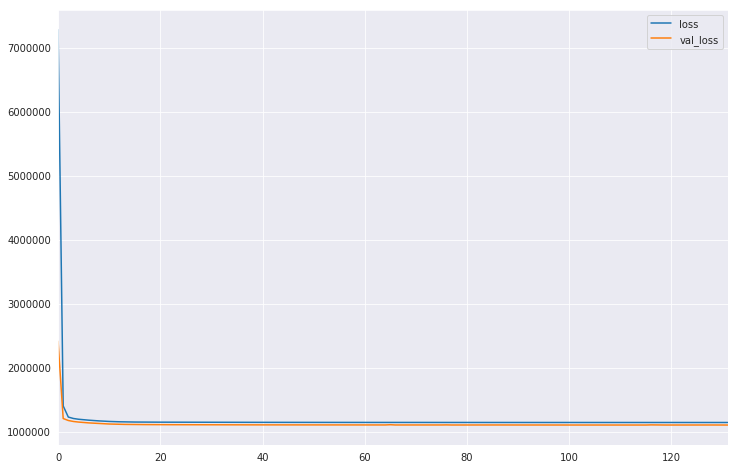

In [154]:
# Plot the loss
sns.set_style('darkgrid')
pd.DataFrame(NN.history.history)[['loss','val_loss']].plot(figsize=[12,8])

### Note:

The graph above is the loss (MSE) on both training and testing set. Both set can reduce the loss fairly quick in the first several epochs and hard to get any more significant improvement once the MSE comes down to around 1.08E^6. It is slightly better than the result of Random Forest. Among all the different algos we have tried on this project, Neural Network is the one I'll take because it yields the least MSE.

In [155]:
# Save the scaler and trained model

dump(newscaler, open('newscaler.pkl', 'wb'))
NN.save('model_predict_delivery_duration.h5')

## Model Interpretation: Shapley Values

Even though we picked the NN as the final model, but it was trained without the feature of store primary category. I still want to check if that feature is valuable so I choose to use the previous Random Forest model to analyze the feature contributions. The RF model's performance is just slightly worse than the NN model so it should be fine; in addition, that model contains all features.

In [39]:
explainer = shap.TreeExplainer(model_RF)

In [ ]:
# This analysis takes very long time to run too. So I will have to use only a sub-sample of the training set.
shap_values = explainer.shap_values(X_train[:100])

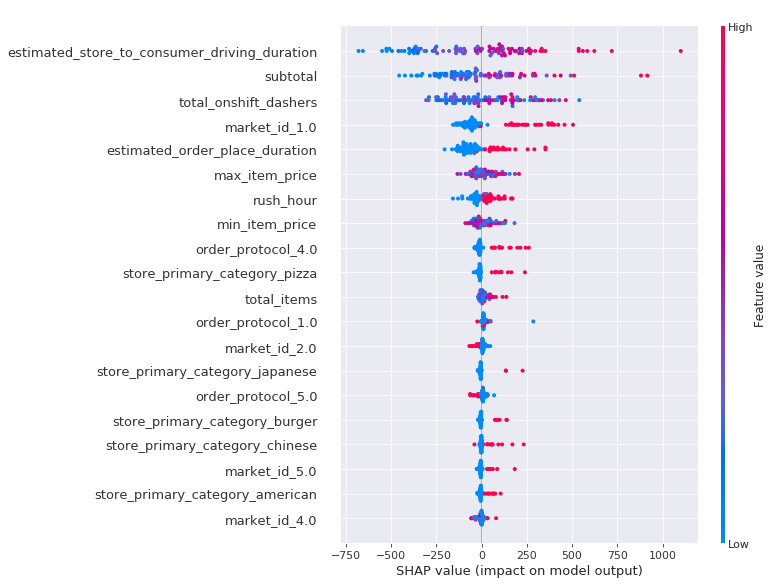

In [43]:
# Visualize the results
shap.summary_plot(shap_values, features=X_train[:100], feature_names=Xfeature_list)

### Note:

From the graph above we can see the top 5 features which have the most impact on the model output are: 

"estimated_store_to_consumer_driving_duration";

"subtotal";

"total_onshift_dashers";

"market_id_1.0";

"estimated_order_place_duration"

And, their impact are similar to each other: higher values in these features tend to drive larger prediction values, namely longer delivery duration. Among these five, "market_id_1.0" is interesting as we know it is a binary indicator, so this feature is basically saying this city is generally slow in delivery maybe because of bad traffic or so.

Another interesting feature is "total_onshift_dashers" because saying larger # of onshift dashers nearby makes delivery duration longer looks kind of counter-intuitive at the firt glance. But, a potential reason behind the scene may be that the fact many dashers gathering around one area means the restaurants in this area are popular and have lots of orders, that's way the dashers gather there. Having received many orders will in turn cause the restaurant being slow processing them because the cooking cannot be that quick. So overall the waiting time is longer mostly due to the restaurants but not the dashers. As a sidenote, this Shapley result is analyzed based on only 100 observations due to the constraint in time. If running it on a larger sample it should give more solid conclusions.

## Customized Model Evaluation Metric and Model Refinement

Other than the MSE, I also customized an evaluation metric to reflect the specific cost of errors to the business, based on the following information given in the instructions: "Order lateness / underprediction of delivery time is of particular concern as past experiments suggest that underestimating delivery time is roughly twice as costly as
overestimating it." Basically it means we want to double the penalty on the positive residuals compared with negative residuals.

There are two ways to incorporate this into modeling:

1. Use the customized metric as a new Loss function and rebuild all the above models, then re-test their performance to pick the winner. However, this will need heavy coding for all the models to be built from scratch because the sklearn library we are using is not designed to let us insert customized loss function. Having considered the time this option is gonna take, I choose not to take this route at the moment. But, it's something worth doing if time and resource is sufficient.


2. Still go on using the current best available model (the NN) and repeat doing incremental change on the final predictions toward one direction (positive direction, because we hate underprediction more than overprediction) until reaching the optimal point where the new customized evaluation metric reaches it's lowest. This method is not that exquisite math compared with customizing the Loss function but still roughly catches the main idea, and it takes less time to code it. So this is what I'm going to try.

In [156]:
def new_metric(a, b):
    '''
    Calculate modified MSE that if (y_i - yhat_i) >= 0 then assign the squared error a weight of 2
    otherwise assign a weight of 1.
    
    INPUT: 
        a = actual list of y ;
        b = predicted list of y; ( b should have the same length with a)
    
    OUTPUT:
        modified_MSE = Value of the metric
    
    '''
    arr_y = np.array(a)
    arr_yhat = np.array([b[i][0] for i in range(0, len(b))])
    
    # all the elements squared and sum, no matter positive or negative
    SSE_part1 = np.sum((arr_y - arr_yhat)**2) 
    
    # the positive elements squared and sum again, which is equavalent to counting them twice
    # do the computation in this way will avoid for loop thru iteratives. Numpy array is vector computation
    # which is a lot faster than for loop
    SSE_part2 = np.sum((np.array(list(filter(lambda x: x>=0, (arr_y - arr_yhat))))**2)) 
    
    modified_MSE = (SSE_part1 + SSE_part2)/len(a)
    
    return modified_MSE
        

In [157]:
new_metric(newy_test,predictions_NN)

1877262.5900496019

### Note:

Compared with the previous MSE, the value of our new metric is larger. This is because all underestimations are double penalized so we have bigger error. This is more aligned with the true loss to the business.

In [131]:
# Calculate the new metric for incremental changes on prediction values, each time increase by 5 seconds
modified_MSE_list = []
increase_value = []
for i in np.arange(10,505,5):
    modified_MSE_list.append(new_metric(newy_test,predictions_NN+i))
    increase_value.append(i)

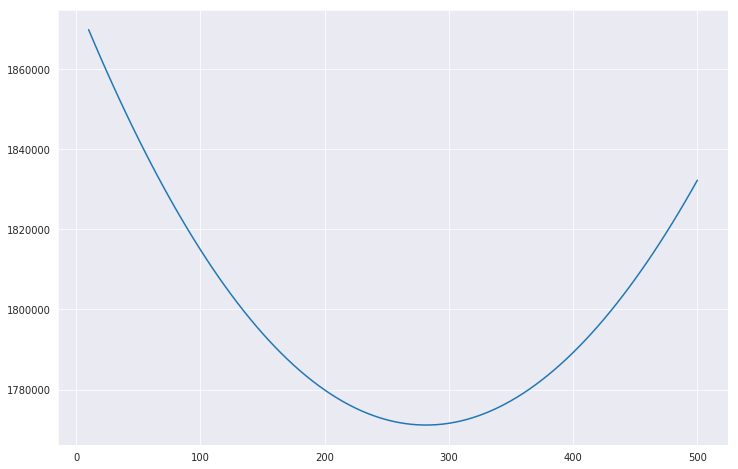

In [132]:
plt.figure(figsize=(12,8))
sns.lineplot(x = increase_value, y=modified_MSE_list)

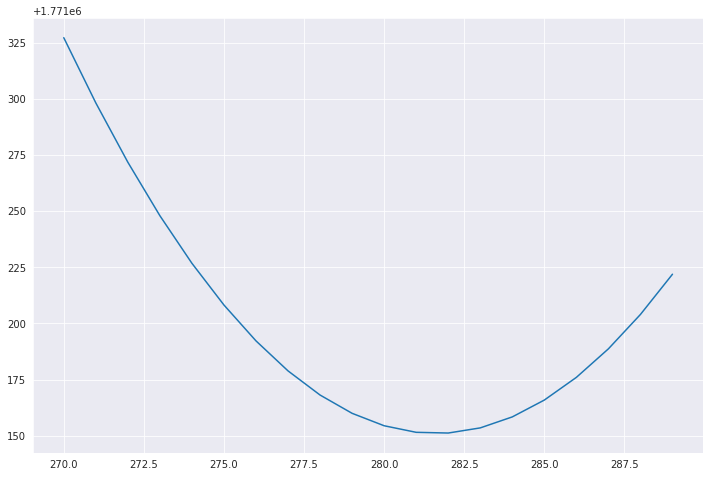

In [134]:
# We can see the optimal point is between 200 and 300 seconds increase. Let's zoom in

# Calculate the new metric for incremental changes on prediction values, each time increase by 1 second
modified_MSE_list = []
increase_value = []
for i in np.arange(270,290,1):
    modified_MSE_list.append(new_metric(newy_test,predictions_NN+i))
    increase_value.append(i)

plt.figure(figsize=(12,8))
sns.lineplot(x = increase_value, y = modified_MSE_list)

### Note:

The optimal point is 282 seconds! So if we make predictions using our NN model, and then increase all predictions by 282 seconds, we should arrive at the best result according our new customized metric. This new prediction will have larger MSE because it leans to overall overestimation, but it will be good to the business since we have penalized underestimation harder.

## Make Final Predictions

In [193]:
# This is the pipeline for data preprocessing
def pre_process(filename):
    '''
    This data preprocessing pipeline can be used individually in pipeline management systems like Apache Airflow,
    but need to make sure the necessary libraries are imported in the same file where this function resides.
    
    INPUT:
        filename = source file name
        
    OUTPUT:
        X_processed = processed data ready to work with model
    '''
    
    # Read data
    df = pd.read_csv(
        filename, 
        header=0
    )
    
    df['created_at'] = pd.to_datetime(df['created_at'])
    df.drop(['store_id','store_primary_category','num_distinct_items','total_busy_dashers','total_outstanding_orders'],axis=1, inplace=True)
    
    df['market_id'].fillna(value=0.0, inplace=True)
    df['order_protocol'].fillna(value=0.0, inplace=True)
    
    col_list = ['min_item_price', 'max_item_price', 'total_onshift_dashers','estimated_store_to_consumer_driving_duration']

    for col in col_list:
        df[col] = df[col].apply(lambda x: x if x>=0 else 0.0)
        
    df['rush_hour'] = df['created_at'].apply(lambda x: 1 if (x - pd.Timedelta(8, unit='h')).hour in [6,7,8,9,15,16,17,18] else 0)
    
    df.drop(['created_at'],axis=1, inplace=True)
    
    cate_list = ['market_id','order_protocol']

    df = pd.get_dummies(
            df, 
            columns=cate_list, 
            drop_first=True
    )
    
    # This part must be hard coded because the saved model only takes a fixed # and order of features
    # This is also the last layer of defense what goes into the model is in its correct shape
    df = df[['total_items','subtotal','min_item_price','max_item_price','total_onshift_dashers','estimated_order_place_duration',
              'estimated_store_to_consumer_driving_duration','rush_hour','market_id_1.0','market_id_2.0',
              'market_id_3.0','market_id_4.0','market_id_5.0','market_id_6.0','order_protocol_1.0',
              'order_protocol_2.0','order_protocol_3.0','order_protocol_4.0','order_protocol_5.0',
              'order_protocol_6.0','order_protocol_7.0']]
    
    # Normalize data
    later_scaler = load(open('newscaler.pkl', 'rb'))
    X_processed = later_scaler.transform(df)
    
    return X_processed
    

In [194]:
# Make predictions
later_model = load_model('model_predict_delivery_duration.h5')
prediction_with_MSE = later_model.predict(pre_process('predict_data.csv'))
prediction_with_new_metric = prediction_with_MSE + 282

In [195]:
# Prepare final dataset
Final_Predictions = pd.DataFrame()
Final_Predictions['delivery_id'] = pd.read_csv('predict_data.csv', header=0)['delivery_id']
Final_Predictions['prediction_with_MSE'] = prediction_with_MSE
Final_Predictions['prediction_with_new_metric'] = prediction_with_new_metric

In [199]:
Final_Predictions.to_csv('Final_Predictions.csv', index=False)

# THANK YOU FOR REVIEWING MY WORK!!

Sean